In [1]:
import os, sys
import dotenv

import pandas as pd
import numpy as np
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt

sys.path.append(os.environ.get('PATH_OPENSKY'))
from user_eval import get_df_posts 
from news_outlet_eval import get_news_feed, get_posts_from_nos

dotenv.load_dotenv('.env')    
PATH_DATA = os.environ.get('PATH_OPENSKY') + os.environ.get('PATH_REL_DATA')
PATH_ALL_SENTIMENTS = os.environ.get('PATH_OPENSKY') + 'results/all_sentiments_over_time.csv'

df = pd.read_csv(PATH_ALL_SENTIMENTS, index_col=0)
df


,post_id,user_id,date,labels,sent_label,sent_score,reply_to,thread_root
9,79798842,527934,2024-03-18 01:33:00,NaN,0.0,0.939,79798843.0,79798843.0
34,79798860,527934,2024-03-16 21:16:00,NaN,1.0,0.757,51667361.0,51667361.0
40,79798869,527934,2024-03-16 04:31:00,NaN,0.0,0.791,79798870.0,79798870.0
42,79798871,527934,2024-03-16 02:37:00,NaN,2.0,0.985,79798872.0,79798872.0
80,79798908,527934,2024-03-13 20:05:00,NaN,0.0,0.930,79798838.0,79798838.0
...,...,...,...,...,...,...,...,...
21,1314169,3401925,2024-02-23 15:38:00,NaN,1.0,0.630,1314170.0,1314170.0
33,1314182,3401925,2024-02-13 04:12:00,NaN,1.0,0.634,1314183.0,1314183.0
40,1314189,3401925,2024-02-08 22:14:00,NaN,2.0,0.978,1314190.0,1314190.0
44,1314193,3401925,2024-02-07 08:33:00,NaN,2.0,0.844,1314194.0,1314194.0


In [3]:
df.groupby('sent_label').agg({'sent_label': 'count', 'sent_score': 'mean'})

,sent_label,sent_score
sent_label,,
0.0,1677015,0.744657
1.0,2488950,0.691020
2.0,2463179,0.850170


In [4]:
sent_label_mapping = { 0: 'negative', 1: 'neutral', 2: 'positive'}
df.loc[:, 'sent_label'] = df.sent_label.map(sent_label_mapping)
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df[df['date'].notna()]
df.set_index('date', inplace=True, drop=True)
df

/tmp/ipykernel_852347/2346654185.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['negative' 'neutral' 'negative' ... 'positive' 'positive' 'neutral']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:, 'sent_label'] = df.sent_label.map(sent_label_mapping)


,post_id,user_id,labels,sent_label,sent_score,reply_to,thread_root
date,,,,,,,
2024-03-18 01:33:00,79798842,527934,NaN,negative,0.939,79798843.0,79798843.0
2024-03-16 21:16:00,79798860,527934,NaN,neutral,0.757,51667361.0,51667361.0
2024-03-16 04:31:00,79798869,527934,NaN,negative,0.791,79798870.0,79798870.0
2024-03-16 02:37:00,79798871,527934,NaN,positive,0.985,79798872.0,79798872.0
2024-03-13 20:05:00,79798908,527934,NaN,negative,0.930,79798838.0,79798838.0
...,...,...,...,...,...,...,...
2024-02-23 15:38:00,1314169,3401925,NaN,neutral,0.630,1314170.0,1314170.0
2024-02-13 04:12:00,1314182,3401925,NaN,neutral,0.634,1314183.0,1314183.0
2024-02-08 22:14:00,1314189,3401925,NaN,positive,0.978,1314190.0,1314190.0


In [14]:
sent_label_counts = df.groupby('sent_label').agg({'sent_label': 'count', 'sent_score': 'mean'})
sent_label_counts['total'] = sent_label_counts['sent_label'].sum()
sent_label_counts['percentage'] = sent_label_counts['sent_label'] / sent_label_counts['total']
sent_label_counts

,sent_label,sent_score,total,percentage
sent_label,,,,
negative,1677015,0.744657,6629144,0.252976
neutral,2488950,0.691020,6629144,0.375456
positive,2463179,0.850170,6629144,0.371568


(array([0, 1, 2]),
 [Text(0, 0, 'negative'), Text(1, 0, 'neutral'), Text(2, 0, 'positive')])

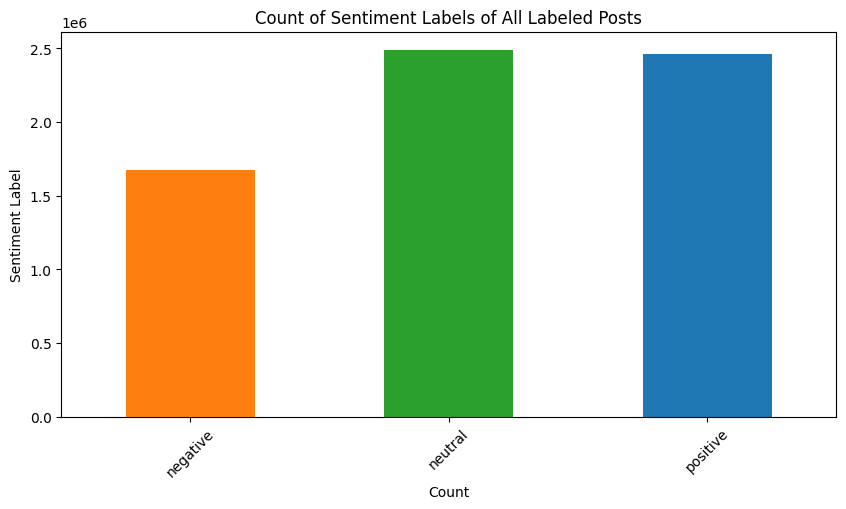

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))
sent_label_counts.sent_label.plot(kind='bar', ax=ax, color=['#ff7f0e', '#2ca02c', '#1f77b4'])
ax.set_ylabel('Sentiment Label')
ax.set_xlabel('Count')
ax.set_title('Count of Sentiment Labels of All Labeled Posts')
plt.xticks(rotation=45)

array([[<Axes: title={'center': 'sent_label'}>]], dtype=object)

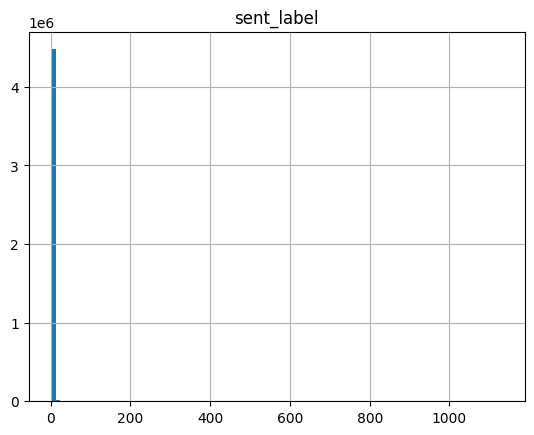

In [8]:
df.groupby('reply_to').agg({'sent_label': 'count'}).hist(bins=100)   

In [11]:
df.dropna(subset=['reply_to', 'thread_root']).reply_to.nunique()

4493826

In [10]:
df.thread_root.nunique()

4493826